<a href="https://colab.research.google.com/github/HarishDeepak/Integrating-Spatial-and-Temporal-Insights-Alzheimer-s-Disease-Detection-/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/output2.csv')
df.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,class
0,-1.015648,0.607713,-0.278908,3.281630,-0.166339,-0.650203,0.325227,1.080925,-0.043044,1.040308,-0.470734,2.380987,-2.885372,-0.808315,-1.178216,2.085553,0.446559,-0.658926,1.179631,1
1,-1.011948,1.346769,0.020103,2.134579,-0.012008,-0.686096,-0.375885,0.863424,-0.210734,0.761145,0.397118,1.535753,2.249918,-0.922754,-1.211055,0.023527,0.618459,-0.421055,0.491663,1
2,-1.022440,0.207813,-1.064155,0.507249,-1.244722,-0.507988,0.557868,0.966547,-0.316767,1.595486,-1.313909,1.141109,-0.576171,0.046831,-0.870213,0.742418,-0.269365,-0.146880,1.383104,1
3,-0.989154,1.618854,-0.578640,0.233035,0.354767,-0.757666,0.310302,0.934652,-0.597214,1.244345,1.265215,0.960180,-0.418612,-0.097890,-1.134101,-1.221621,0.585634,1.895396,0.456129,1
4,-1.018839,0.271158,0.378539,-0.154249,0.808012,-0.382423,-0.330254,0.087670,0.552186,0.584269,-1.634352,-0.439620,-0.558520,0.227478,0.000448,-0.189212,0.404759,0.289026,-0.277294,1


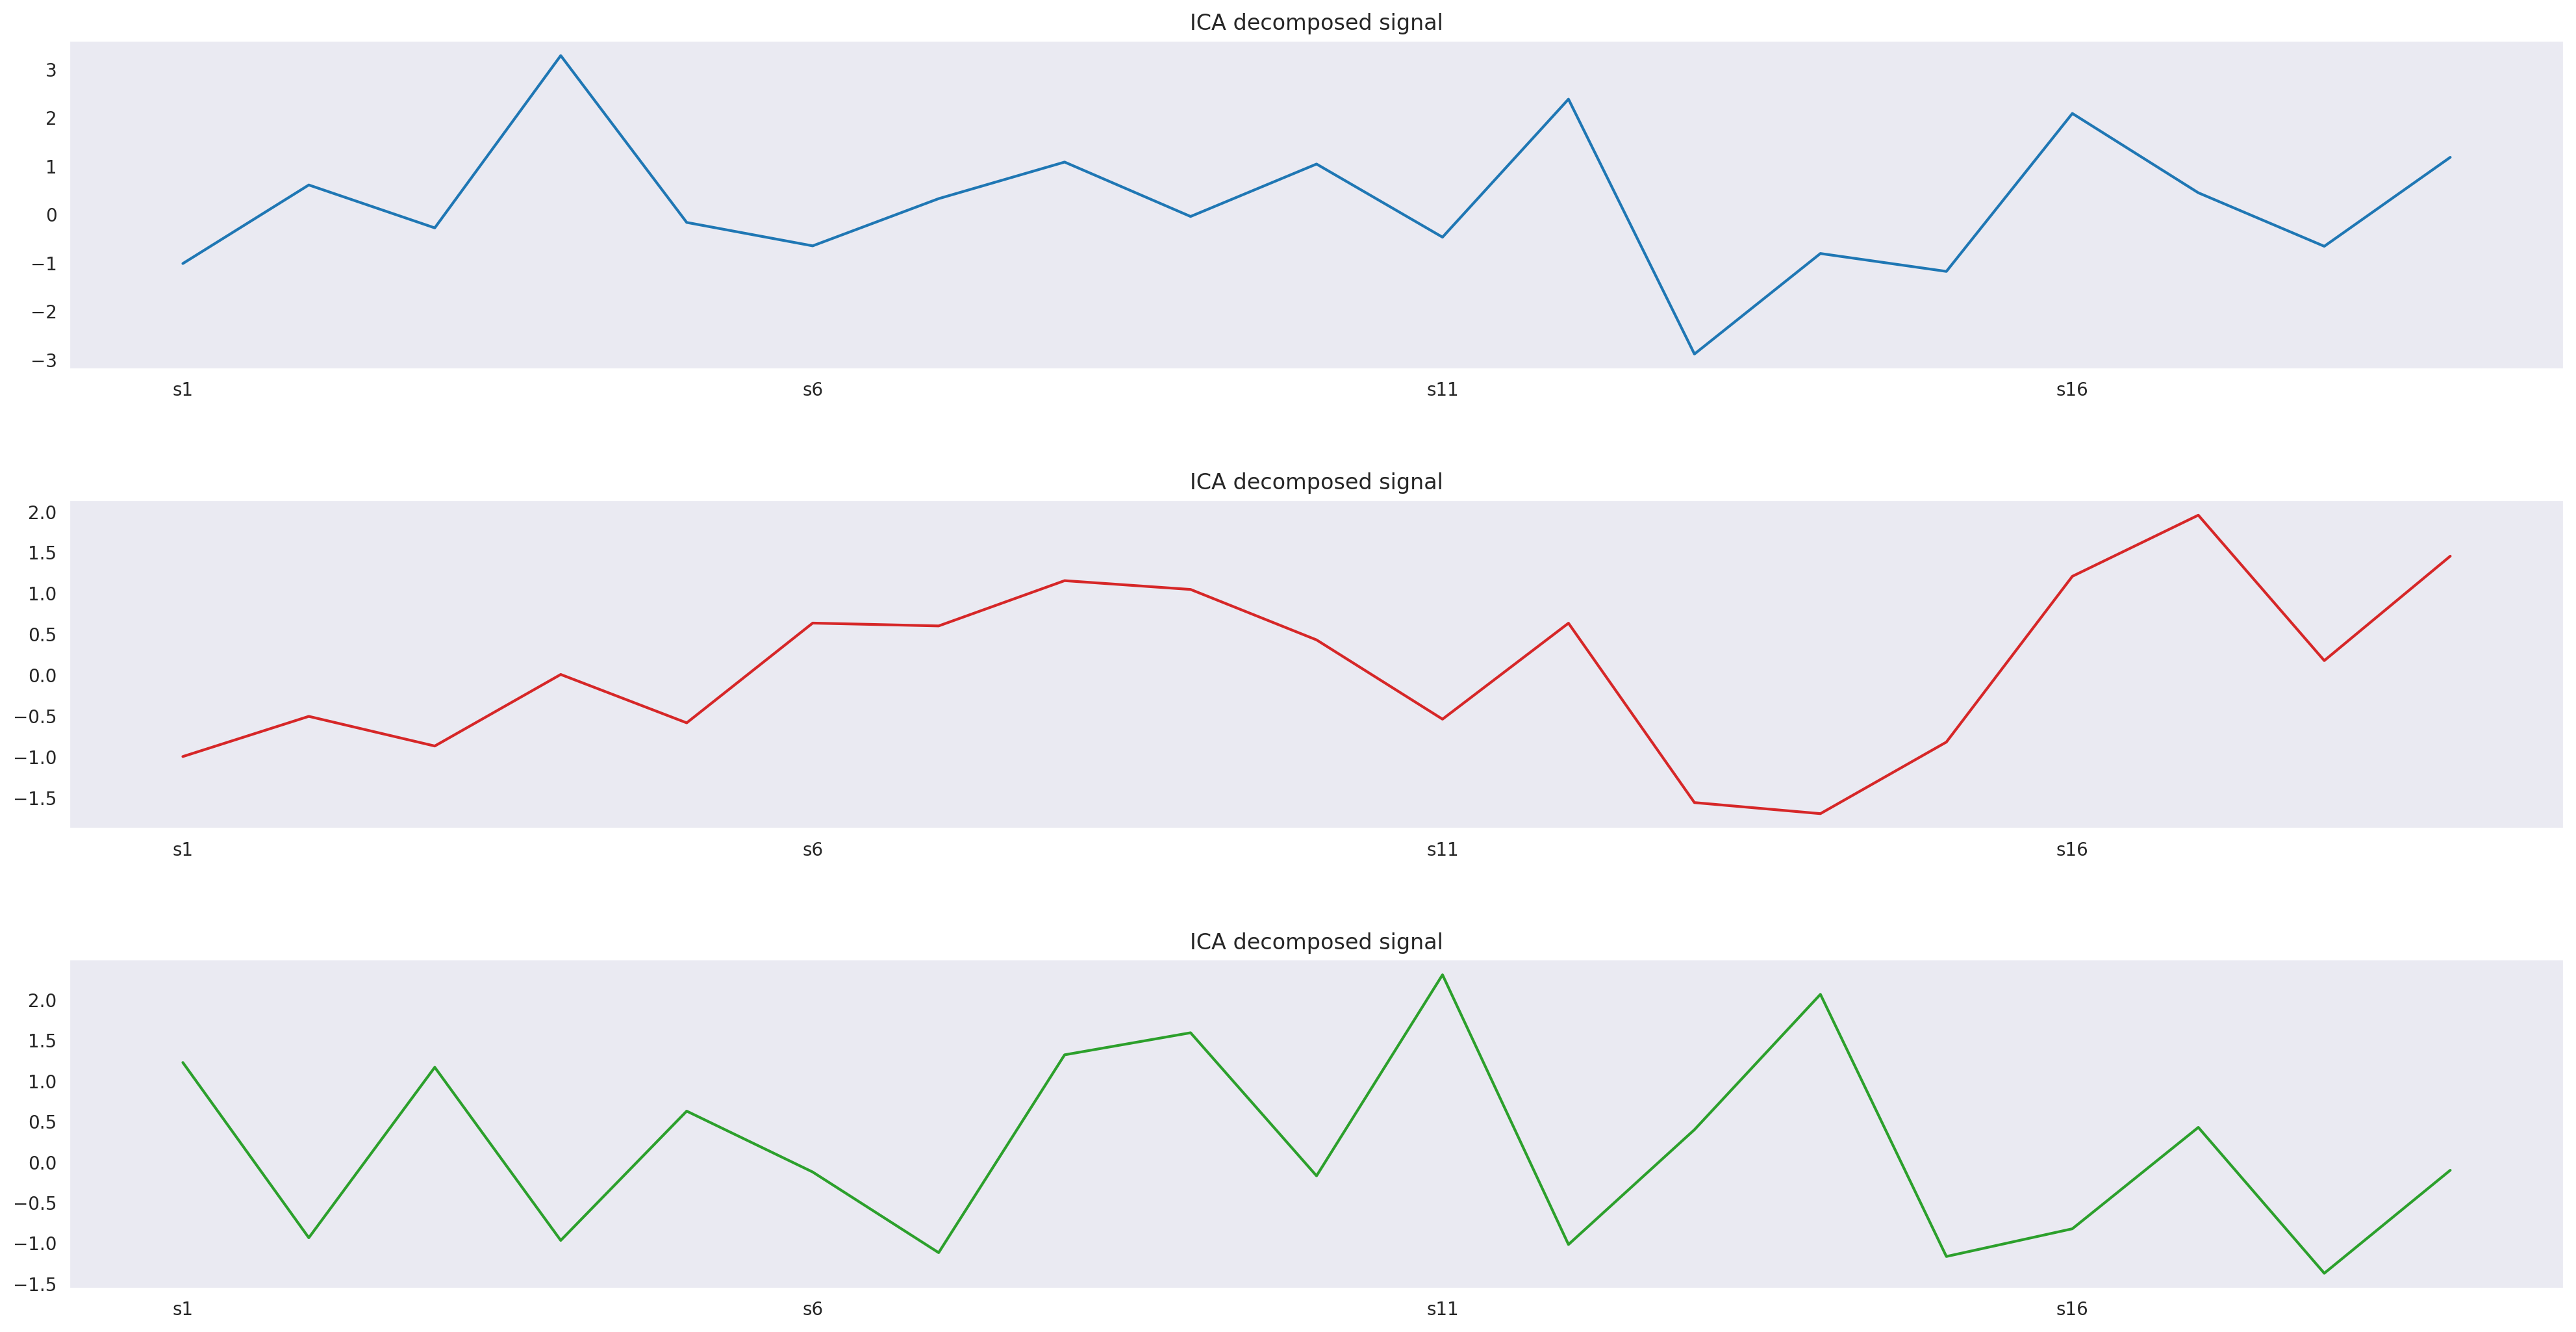

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))

df.loc[0, 's1':'s19'].plot(title='ICA decomposed signal', color='tab:blue', ax=axes[0])
df.loc[10, 's1':'s19'].plot(title='ICA decomposed signal', color='tab:red', ax=axes[1])
df.loc[30, 's1':'s19'].plot(title='ICA decomposed signal', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1,
                    right=0.9, top=0.9,
                    wspace=0.4, hspace=0.4)

In [ ]:
Y = df['class'].copy()
X = df.drop('class', axis=1).copy()

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [ ]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [ ]:
i_gru = Input(shape=(X_train.shape[1], 1))

x_gru = GRU(500, return_sequences=True)(i_gru)
x_gru = Flatten()(x_gru)
y_gru = Dense(3, activation='softmax')(x_gru)

model_gru = Model(i_gru, y_gru)

model_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 1)]           0         
                                                                 
 gru (GRU)                   (None, 19, 500)           754500    
                                                                 
 flatten (Flatten)           (None, 9500)              0         
                                                                 
 dense (Dense)               (None, 3)                 28503     
                                                                 
Total params: 783003 (2.99 MB)
Trainable params: 783003 (2.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_gru_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

model_gru.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

gru_h = model_gru.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
1/2 [==============>...............] - ETA: 7s - loss: 1.0987 - accuracy: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to ./best_gru_model.h5
2/2 [==============================] - 8s 499ms/step - loss: 1.0764 - accuracy: 0.4364 - val_loss: 0.9922 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.9599 - accuracy: 0.7500
Epoch 2: val_accuracy did not improve from 0.75000
2/2 [==============================] - 0s 40ms/step - loss: 0.9236 - accuracy: 0.7818 - val_loss: 0.8778 - val_accuracy: 0.7500 - lr: 9.0484e-04
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.8033 - accuracy: 0.7812
Epoch 3: val_accuracy did not improve from 0.75000
2/2 [==============================] - 0s 39ms/step - loss: 0.7960 - accuracy: 0.7818 - val_loss: 0.7687 - val_accuracy: 0.7500 - lr: 8.1873e-04
Epoch 4/50
1/2 [==============>...............] - ETA: 0s - loss: 0.6698 - accuracy: 0.7812
Epoch 4: 

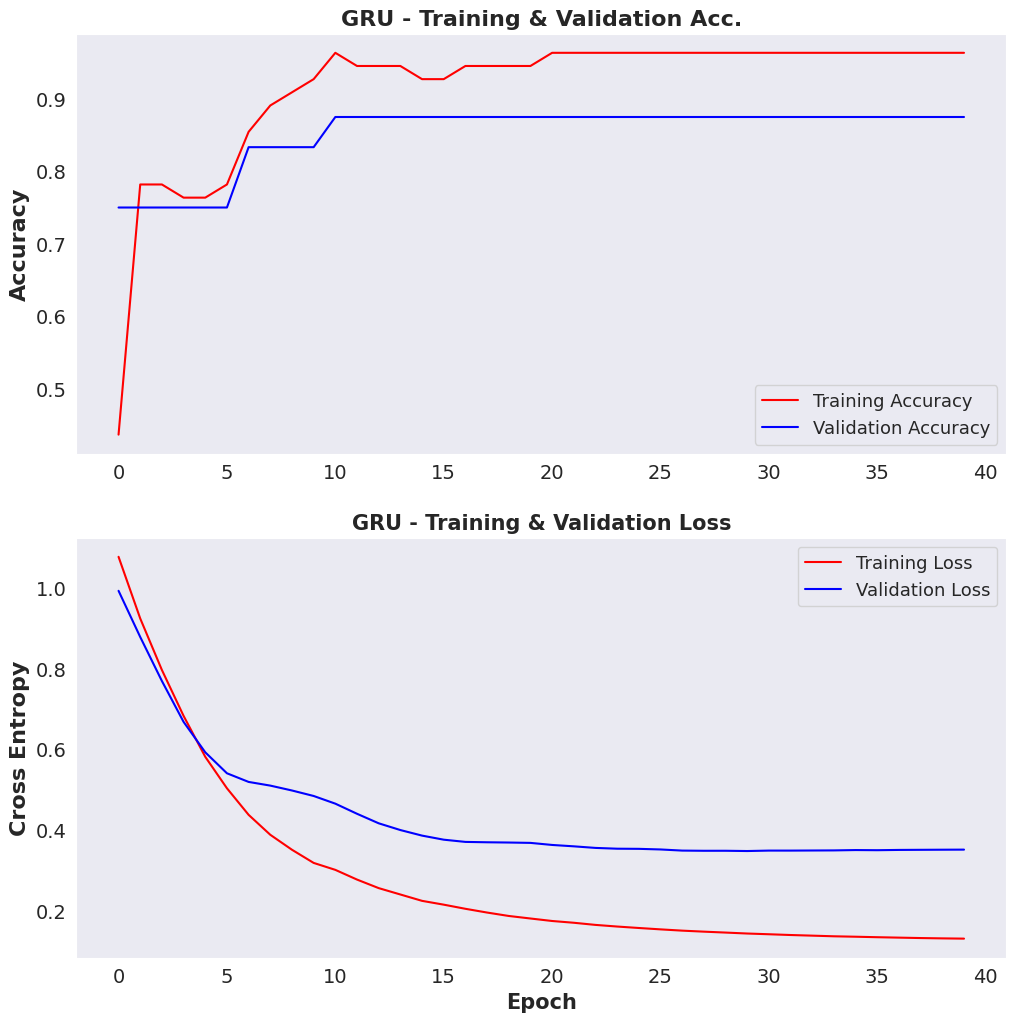

In [ ]:
# Show History
acc = gru_h.history['accuracy']
val_acc = gru_h.history['val_accuracy']

loss = gru_h.history['loss']
val_loss = gru_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [ ]:
gru_best = load_model('./best_gru_model.h5')
gru_acc = gru_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc. GRU: {:.3f}%".format(gru_acc * 100))

Test Acc. GRU: 68.571%


In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), gru_best.predict(x_test))))
y_test = y_test.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.22      0.15      0.18        13
           2       0.23      0.27      0.25        11
           3       0.00      0.00      0.00        11

    accuracy                           0.14        35
   macro avg       0.11      0.11      0.11        35
weighted avg       0.16      0.14      0.15        35



Normalized confusion matrix


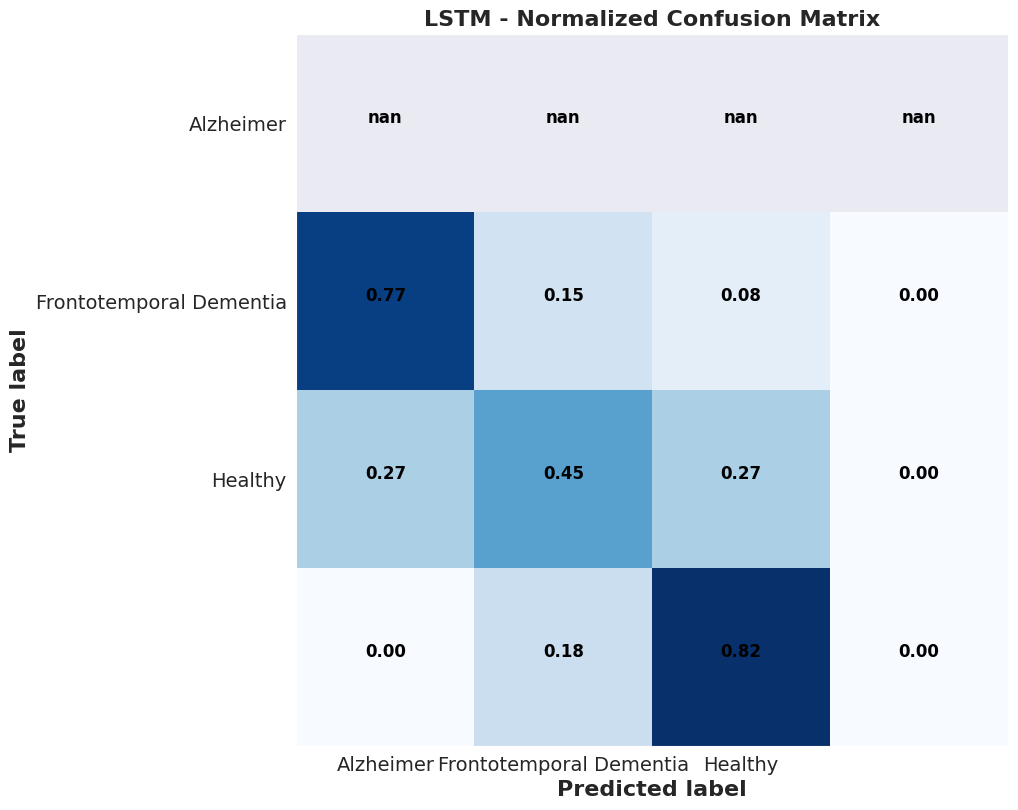

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Alzheimer', 'Frontotemporal Dementia', 'Healthy'], normalize=True,
                      title='LSTM - Normalized Confusion Matrix')
plt.show()